# Machine Learning- COIY065H7

## Coursework, WAME Optimiser Evaluation

Load modules for use throughout the workbook

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn import Module
from torch.optim import *
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
%matplotlib inline

import time


Verify versions of ML libraries being used

In [2]:
print(torch.__version__)
print(torch.version.cuda)

1.5.0
10.2


## Routines to be used 

PrintResults will output a table of Precision and Recall for each class

In [3]:
def PrintResults(predictions, actuals):
    ynp = predictions.numpy()
    testnp = actuals.numpy()
    print("Class \t Cases \t TP \t FP \t Precision \t Recall")
    allcases = 0
    allTP = 0
    allFP = 0
    for i in range(0,6):
        cases = sum(testnp==i)
        allcases += cases
        TP = sum((ynp==i) & (testnp==i))
        allTP += TP
        FP = sum((ynp==i) & (testnp!=i))
        allFP += FP
        Precision = TP / (TP + FP + 0.000000001)
        Recall = TP / cases
        print(i, "\t", cases, "\t" ,TP, "\t", FP, "\t", round(Precision, 3), "\t", "\t", round(Recall, 3))
    Precision = allTP / (allTP + allFP + 0.000000001)
    Recall = allTP / allcases
    print("Total", "\t", allcases, "\t" ,allTP, "\t", allFP, "\t", round(Precision, 3), "\t", "\t", round(Recall, 3))
    

Check returns the class predictions and accuracy score of a model

In [4]:
def Check(Xvals, Yactuals, model):
    predictraw = model(Xvals.to(device)).detach().cpu()
    predict = np.argmax(predictraw, axis=-1)
    predict_score = predict == Yactuals
    correct = np.sum(predict_score.numpy(), axis=-1)
    sumtot = predict_score.shape[0]
    score = correct / sumtot
    return (predict, score)

## Wame optimizer

Logic for the optimiser follows the paper by Mosca, 

A. Mosca and G. D. Magoulas, ‘Training convolutional networks with weight-wise adaptive learning rates’, in ESANN, 2017.

The code for the PyTorch optimizer implementation was adapted from the PyTorch souce code using -

PyTorch optimizer class code: https://pytorch.org/docs/stable/optim.html

Example of RProp implementation: https://pytorch.org/docs/stable/_modules/torch/optim/rprop.html

And guidance on writing a custom optimizer for AdamW: http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html


In [5]:
class wame(Optimizer):


    def __init__(self, params,lr=1e-3, alpha=0.9, etas=(0.1, 1.2), zetas=(0.01, 100), epsilon=1e-10, debug=False ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= alpha:
            raise ValueError("Invalid learning rate: {}".format(alpha))
        if not 0.0 < etas[0] < 1.0 < etas[1]:
            raise ValueError("Invalid eta values: {}, {}".format(etas[0], etas[1]))

        defaults = dict(alpha=alpha, etas=etas, zetas=zetas, lr=lr, epsilon=epsilon, debug=debug)
        super(wame, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
   
        for group in self.param_groups:    
            etaminus, etaplus = group['etas']
            zeta_min, zeta_max = group['zetas']
            alpha = group['alpha']
            lr = group['lr']
            epsilon = group['epsilon']
            debug = group['debug']
            _p = 0

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('wame does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['prev'] = torch.ones_like(p.data, memory_format=torch.preserve_format)
                    state['prev'] = grad
                    state['Theta'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['Z'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['zeta'] = torch.ones_like(p.data, memory_format=torch.preserve_format)
                    state['gradmult'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    
                    state['step_size'] = grad.new().resize_as_(grad).fill_(group['lr']) ### check on initialisation
                    state['prev'] = grad
                    
                if (_p == 0) & debug:
                    print("Weights at start: ",p.data.sum(), p.data.size())
                step_size = state['step_size']
                Theta = state['Theta']
                Z = state['Z']
                zeta = state['zeta']
                gradmult = state['gradmult']                    
                
                state['step'] += 1

                gradmult = grad.mul(state['prev'])
                zeta[gradmult.gt(0.)] = zeta[gradmult.gt(0.)].mul(etaplus).clamp(zeta_min, zeta_max)
                zeta[gradmult.lt(0.)] = zeta[gradmult.lt(0.)].mul(etaminus).clamp(zeta_min, zeta_max)
                zeta[gradmult.eq(0.)] = 1
                
                Z = Z.mul(alpha).add(zeta.mul(1 - alpha))
                Theta = Theta.mul(alpha).add(grad.mul(grad).mul(1 - alpha))

                step_size = Z.mul(-lr).mul(grad).div(Theta.add(epsilon))

                grad = grad.clone(memory_format=torch.preserve_format)
                
                # update parameters
                p.data = p.data.add(step_size)
                
                if (_p == 0) & debug:
                    print("Step number ", state['step'])
                    print("Weights after update: ",p.data.sum(), p.data.size())
                    print("Updates applied: ",step_size.sum(), step_size.size())
                    print("Theta: ",Theta.sum())
                    print("Z: ",Z.sum())
                    print("zeta: ",zeta.sum())
                    print("grad: ",grad.sum())
                    print("grad_sqd", grad_sqd.sum())
                    print("gradmult", gradmult.sum())
                state['prev'] = grad
                
                _p = _p + 1

        return loss


<function matplotlib.pyplot.show(*args, **kw)>

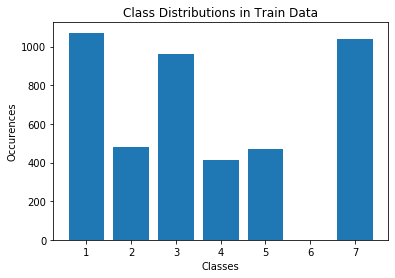

In [6]:
alldata = pd.read_csv("sat.all.csv")
traindata = alldata[alldata['TrainTest'] == 'train']
testdata = alldata[alldata['TrainTest'] == 'test']

distribution = traindata.groupby('Class').count()
plt.bar(distribution.index.values,distribution.iloc[:,0])
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.title('Class Distributions in Train Data')
plt.show

In [7]:
seed = 7
train, validate = train_test_split(traindata, test_size=0.2, random_state=seed, stratify=traindata['Class'], shuffle=True)

trainX = traindata.iloc[:,0:36].to_numpy()
trainY= traindata.iloc[:,36].to_numpy()

testX = testdata.iloc[:,0:36].to_numpy()
testY = testdata.iloc[:,36].to_numpy()

for i in range(1,8):
    trainY[trainY==i] = i-1
    testY[testY==i] = i-1

trainY[trainY==6] = 5
testY[testY==6] = 5

In [8]:
scaler = StandardScaler()
scalerFunc = scaler.fit(trainX)

trainX = scalerFunc.transform(trainX)
testX = scalerFunc.transform(testX)

testX_tensor = torch.from_numpy(testX).float()
testY_tensor = torch.from_numpy(testY).float()

#for i in range(0,36):
#    print(' Feature {} \t Train: {:.6f} {:.6f} Validation: {:.6f} {:.6f} Test: {:.6f} {:.6f}'.format(
#          i,
#          min(trainX[:,i]),max(trainX[:,i]),
#          min(valX[:,i]),max(valX[:,i]),
#          min(testX[:,i]),max(testX[:,i])))

In [9]:
in_features = 36
out_classes = 6

class TestModel(Module):
    def __init__(self, num_units=in_features*2, hidden_layers=4 ):
        
        self.hidden_layers = hidden_layers
        hidden = []
        hidden.append(num_units)
        for i in range(1,hidden_layers):
            hidden.append(max(out_classes*2,int(num_units/2**i)))
        
        super(TestModel, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden[0])

        if hidden_layers > 1:
            self.relu1 = nn.ReLU()
            self.fc2 = nn.Linear(hidden[0], hidden[1])
        if hidden_layers > 2:
            self.relu2 = nn.ReLU()
            self.fc3 = nn.Linear(hidden[1], hidden[2])
        if hidden_layers > 3:
            self.relu3 = nn.ReLU()
            self.fc4 = nn.Linear(hidden[2], hidden[3])
        if hidden_layers > 4:
            self.relu4 = nn.ReLU()
            self.fc5 = nn.Linear(hidden[3], hidden[4])
        if hidden_layers > 5:
            self.relu5 = nn.ReLU()
            self.fc6 = nn.Linear(hidden[4], hidden[5])
        
        self.reluLast = nn.ReLU()
        self.fcLast = nn.Linear(hidden[hidden_layers-1], out_classes)

    def forward(self, x):
        
        hidden_layers = self.hidden_layers
        
        y = self.fc1(x)

        if hidden_layers > 1:
            y = self.relu1(y)
            y = self.fc2(y)
        if hidden_layers > 2:
            y = self.relu2(y)
            y = self.fc3(y)
        if hidden_layers > 3:
            y = self.relu3(y)
            y = self.fc4(y)
        if hidden_layers > 4:
            y = self.relu4(y)
            y = self.fc5(y)
        if hidden_layers > 5:
            y = self.relu5(y)
            y = self.fc6(y)

        y = self.reluLast(y)
        y = self.fcLast(y)
        
        return y

In [10]:
def RunModel(model, epochs, trainX, trainY, valX, valY):
    accuracies = []
    validations = []
    errors = []

    train_score = 0
    epoch = 0

    trainXY_tensor = TensorDataset(trainX, trainY)
    train_loader = DataLoader(trainXY_tensor, batch_size=batch_size)
        
    while (epoch < epochs):
        batch = 0
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)
            opt.zero_grad()
            predict_y = model(train_x)
            error = loss(predict_y, train_label.long())
            error.backward()
            opt.step()

            batch = batch + 1
    

        train_pred, train_score = Check(trainX, trainY, model)
        error = loss(model(trainX), trainY.to(device).long())
        val_pred, val_score = Check(valX, valY, model)

        accuracies.append(train_score)
        validations.append(val_score)
        errors.append(error)
    
        epoch += 1
        
    return(accuracies, errors, validations)

In [11]:
def RunFolds(nfolds, trainX, trainY, outputrequired):
    
    fold = 0
    torch.save(model.state_dict(),'initial_weights.state')

    foldAcc = []
    foldVal =  []
    foldErr = []

    for trainIndex, testIndex in nfolds.split(trainX):
    
        model.load_state_dict(torch.load('initial_weights.state'))

        trainX_tensor = torch.from_numpy(trainX[trainIndex]).float()
        trainY_tensor = torch.from_numpy(trainY[trainIndex]).float()

        valX_tensor = torch.from_numpy(trainX[testIndex]).float()
        valY_tensor = torch.from_numpy(trainY[testIndex]).float()

        time00 = time.perf_counter()
        torch.manual_seed(7)

        acc, val, err = RunModel(model, epochs, trainX_tensor, trainY_tensor, valX_tensor, valY_tensor)
    
        time01 = time.perf_counter()
        train_pred, train_score = Check(trainX_tensor, trainY_tensor, model)
        error = loss(model(trainX_tensor), trainY_tensor.to(device).long()).detach().cpu().numpy()
        val_pred, val_score = Check(valX_tensor, valY_tensor, model)
        if outputrequired:
            print('fold: {} \t accuracy: {:.6f} error: {:.6f} validation accuracy: {:.6f} time {:.3f}s'.format(
               fold + 1, train_score, error, val_score, time01 - time00))

        foldAcc.append(train_score)
        foldVal.append(val_score)
        foldErr.append(error)
    
        fold += 1

    return(foldAcc, foldVal, foldErr)

In [12]:
indir = './DataForRuns/'
infile = 'NumUnits2Adam'
allruns = pd.read_csv(indir + infile + ".csv",sep=",")

In [13]:
allruns.T[0].to_list()

[200.0, 2.0, 512.0, 0.01, 100.0, 10.0]

In [14]:
count = 0

allresults = []

for index,row in allruns.iterrows():
    num_units = int(row['num_units'])
    hidden_layers = int(row['hidden_layers'])
    batch_size = int(row['batch_size'])
    lr = row['lr']
    epochs = int(row['epochs'])
    fold_splits = int(row['fold_splits'])
    
    blurb = False
    
    print("Executing run number", count)
    print('Using {} hidden_layers with {} units in first layer. Batch size of {} for {} epochs. \
{} folds. Learning rate {:.1e}'.format(
            hidden_layers, num_units, batch_size, epochs, fold_splits, lr))
    print()

    if torch.cuda.is_available():
        model = torch.nn.DataParallel(TestModel(num_units=num_units, hidden_layers=hidden_layers)).cuda()
        device = torch.device("cuda")
    else:
        model = TestModel()
        device = torch.device("cpu")

    if blurb:
        print(model)

    optName = "Adam"

    if optName == "Wame":
        opt = wame(model.parameters(), lr=lr)
    if optName == "SGD":
        opt = SGD(model.parameters(), lr=lr)
    if optName == "Adam":
        opt = Adam(model.parameters(), lr=lr)

    loss = CrossEntropyLoss().to(device)
    epochs = 50

    nfolds = KFold(n_splits=fold_splits, shuffle=True)
    
    starttime = time.perf_counter()
    foldAcc, foldVal, foldErr = RunFolds(nfolds, trainX, trainY, blurb)
    runtime= time.perf_counter() - starttime
    
    print('Results Accuracy: mean {:.3f} std {:.3f} Validation Accuracy: mean {:.3f} std {:.3f} \
Runtime {:.2f} seconds'.format(
        np.mean(foldAcc), np.std(foldAcc), np.mean(foldVal), np.std(foldVal), runtime) )
    print()
    print()      
    
    allresults.append(allruns.T[count].to_list() + foldAcc + foldVal + [runtime])
          
    count += 1

Executing run number 0
Using 2 hidden_layers with 200 units in first layer. Batch size of 512 for 100 epochs. 10 folds. Learning rate 1.0e-02

Results Accuracy: mean 0.924 std 0.020 Validation Accuracy: mean 0.892 std 0.023 Runtime 20.57 seconds


Executing run number 1
Using 2 hidden_layers with 150 units in first layer. Batch size of 512 for 100 epochs. 10 folds. Learning rate 1.0e-02

Results Accuracy: mean 0.932 std 0.006 Validation Accuracy: mean 0.900 std 0.015 Runtime 19.06 seconds


Executing run number 2
Using 2 hidden_layers with 100 units in first layer. Batch size of 512 for 100 epochs. 10 folds. Learning rate 1.0e-02

Results Accuracy: mean 0.929 std 0.007 Validation Accuracy: mean 0.891 std 0.011 Runtime 19.09 seconds


Executing run number 3
Using 2 hidden_layers with 80 units in first layer. Batch size of 512 for 100 epochs. 10 folds. Learning rate 1.0e-02

Results Accuracy: mean 0.927 std 0.005 Validation Accuracy: mean 0.893 std 0.017 Runtime 19.20 seconds


Executing

In [15]:
import csv
with open(indir + infile + 'Results.csv', 'w+') as file:
    writer = csv.writer(file)
    writer.writerows( allresults )

In [ ]:
model.load_state_dict(torch.load('initial_weights.state'))

trainX_tensor = torch.from_numpy(trainX).float()
trainY_tensor = torch.from_numpy(trainY).float()

valX_tensor = torch.from_numpy(testX).float()
valY_tensor = torch.from_numpy(testY).float()

time00 = time.perf_counter()
torch.manual_seed(7)

trainXY_tensor = TensorDataset(trainX_tensor, trainY_tensor)
train_loader = DataLoader(trainXY_tensor, batch_size=batch_size)

acc, val, err = RunModel(model, epochs, trainX_tensor, trainY_tensor, valX_tensor, valY_tensor)
    
time01 = time.perf_counter()
train_pred, train_score = Check(trainX_tensor, trainY_tensor, model)
error = loss(model(trainX_tensor), trainY_tensor.to(device).long())
val_pred, val_score = Check(valX_tensor, valY_tensor, model)

print('Overall: \t accuracy: {:.6f} error: {:.6f} validation accuracy: {:.6f} time {:.3f}s'.format(
        train_score, error, val_score, time01 - time00))

In [ ]:
plotrange = epochs

plt.plot(range(plotrange), acc[0:plotrange], color='green')
plt.plot(range(plotrange), val[0:plotrange], color='blue')
plt.plot(range(plotrange), err[0:plotrange], color='r')
title = "Optimizer {} reached accuracy {:.3f} in {:.2f} seconds".format(optName, train_score, time01 - time00)
plt.xlabel('Epochs')
plt.ylabel('Accuracy, Validation and Error')
plt.title(title)
plt.show()

In [ ]:
PrintResults(val_pred, valY_tensor)